# Springboard Capstone Project 2
## Combined Model Training
___

Another potential solution to the class imbalance problem is to combine both the model trained on the full image set and that trained on the downsampled image set. A new Keras model was created such that the input was fed into both models, and the outputs of the models were combined into a 10-node layer. Then, a new output layer of 5 nodes was trained on the downsampled image set to learn the patterns in this 10-node layer.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.applications import VGG16
from keras.models import load_model, Model
from keras.layers import Dense, concatenate, Input, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import importlib as imp

# custom module for capstone 2
import cap2tools as c2t
imp.reload(c2t)

Using TensorFlow backend.


<module 'cap2tools' from 'C:\\Users\\Nils\\Documents\\GitHub\\Springboard-Capstone-2-local-yelp\\cap2tools.py'>

In [2]:
# configure GPU memory usage by tensorflow
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.90
K.tensorflow_backend.set_session(K.tf.Session(config=config))

In [3]:
# define paths to image directories
photos_path = 'C:/Users/Nils/Documents/GitHub/Springboard-Capstone-2-local-yelp/downsampled/'
train_path = photos_path + 'train'
valid_path = photos_path + 'val'

# build image generators to feed CNN
train_batches, valid_batches = c2t.build_datagens(train_path, valid_path, augment=True)

Found 5480 images belonging to 5 classes.
Found 525 images belonging to 5 classes.


In [4]:
# save weights only for base models
base_model_large = load_model('models/full_set_model.h5')
base_model_large.save_weights('models/full_set_model_weights.h5')
del base_model_large

base_model_downsample = load_model('models/downsample_model_1.h5')
base_model_downsample.save_weights('models/downsample_model_1_weights.h5')
del base_model_downsample

In [5]:
# rebuild full image set model architecture
widths = (1000, 1250)
dropout1 = 0
dropout2 = 0.2

base_model = VGG16(include_top=False, 
                   weights=None, 
                   input_shape=(224, 224, 3))

inputs = base_model.output
x = Flatten()(inputs)
x = Dense(widths[0], activation='relu')(x)
x = Dropout(dropout1)(x)
x = Dense(widths[1], activation='relu')(x)
x = Dropout(dropout2)(x)
preds = Dense(5, activation='relu')(x)

base_model_full = Model(inputs=base_model.inputs, outputs=preds)
base_model_full.name = 'full'
del base_model

# load trained weights into model
base_model_full.load_weights('models/full_set_model_weights.h5')

# set weights to untrainable
for layer in base_model_full.layers:
    layer.trainable = False

In [6]:
# rebuild downsampled model architecture
widths = (1000, 1250)
dropout1 = 0
dropout2 = 0.2

base_model = VGG16(include_top=False, 
                   weights=None, 
                   input_shape=(224, 224, 3))

inputs = base_model.output
x = Flatten()(inputs)
x = Dense(widths[0], activation='relu')(x)
x = Dropout(dropout1)(x)
x = Dense(widths[1], activation='relu')(x)
x = Dropout(dropout2)(x)
preds = Dense(5, activation='relu')(x)

base_model_down = Model(inputs=base_model.inputs, outputs=preds)
base_model_down.name = 'down'
del base_model

# load trained weights into model
base_model_down.load_weights('models/downsample_model_1_weights.h5')

# set weights to untrainable
for layer in base_model_down.layers:
    layer.trainable = False

In [7]:
# construct combined model
inputs = Input(shape=(224, 224, 3,), name='main_input')
full_out = base_model_full(inputs)
down_out = base_model_down(inputs)

# combine outputs of base models into one layer
x = concatenate([full_out, down_out])

# new output layer
preds = Dense(5, activation='softmax')(x)

# compile model
model = Model(inputs=inputs, outputs=preds)
model.compile(optimizer=Adam(lr=0.1, decay=0.1), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# clear other models from memory
del base_model_full
del base_model_down

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
full (Model)                    (None, 5)            41061193    main_input[0][0]                 
__________________________________________________________________________________________________
down (Model)                    (None, 5)            41061193    main_input[0][0]                 
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 10)           0           full[1][0]                       
                                                                 down[1][0]                       
__________

In [9]:
# define callbacks
savepath = 'models/combined_model.h5'
saver = ModelCheckpoint(savepath,
                        monitor='val_loss',
                        verbose=1,
                        save_best_only=True)

stopper = EarlyStopping(monitor='val_loss', 
                        patience=3, 
                        verbose=1)

# train model
n_epochs = 20

history = model.fit_generator(train_batches, 
                              validation_data=valid_batches,
                              epochs=n_epochs, 
                              verbose=1, 
                              callbacks=[saver, stopper])

Epoch 1/20
685/685 [==============================] - 98s 143ms/step - loss: 0.3546 - acc: 0.8714 - val_loss: 0.2462 - val_acc: 0.9105

Epoch 00001: val_loss improved from inf to 0.24620, saving model to models/combined_model.h5
Epoch 2/20
685/685 [==============================] - 96s 141ms/step - loss: 0.2865 - acc: 0.8956 - val_loss: 0.2401 - val_acc: 0.9086

Epoch 00002: val_loss improved from 0.24620 to 0.24005, saving model to models/combined_model.h5
Epoch 3/20
685/685 [==============================] - 96s 140ms/step - loss: 0.2945 - acc: 0.8920 - val_loss: 0.2374 - val_acc: 0.9105

Epoch 00003: val_loss improved from 0.24005 to 0.23741, saving model to models/combined_model.h5
Epoch 4/20
685/685 [==============================] - 96s 140ms/step - loss: 0.2896 - acc: 0.8922 - val_loss: 0.2370 - val_acc: 0.9105

Epoch 00004: val_loss improved from 0.23741 to 0.23699, saving model to models/combined_model.h5
Epoch 5/20
685/685 [==============================] - 96s 140ms/step - l

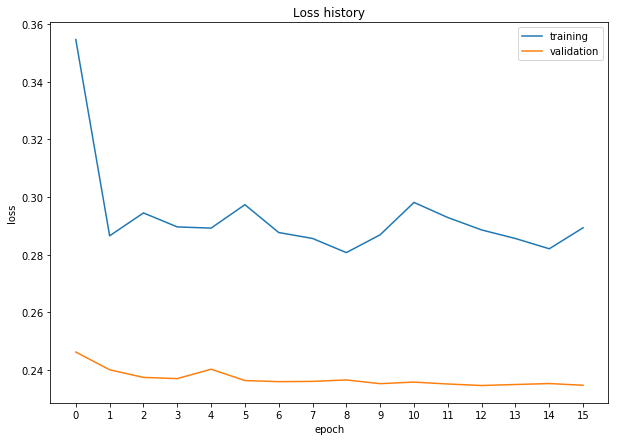

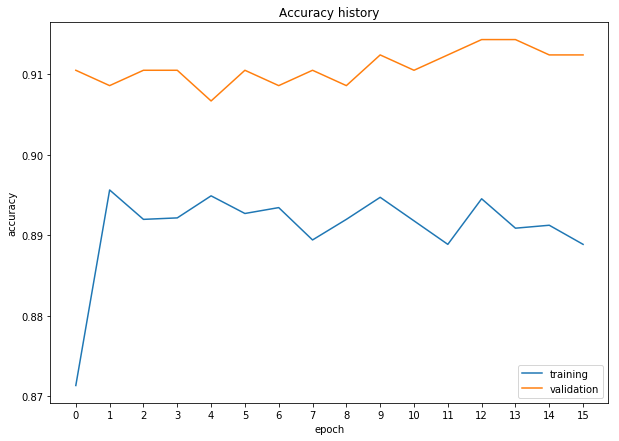

In [10]:
# plot model training history
c2t.plot_history(history)

In [11]:
# evaluate model on full validation set
model_paths = {'model': savepath}
valid_path_full = 'H:/springboard/other_data/yelp/Photos/final_photos/val'
model_metrics = c2t.eval_models(model_paths, valid_path_full)['model']
c2t.print_eval(model_metrics)

Building image generator...
Found 20000 images belonging to 5 classes.
Loading models/combined_model.h5
Evaluating models/combined_model.h5
Evaluation complete.

accuracy:  90.43%
loss:  0.2513
pcr:  [0.8695 0.9323 0.8189 0.9905 0.9109]
mean pcr:  90.44%
confusion matrix: 


[[653, 19, 52, 7, 20],
 [542, 12345, 184, 105, 66],
 [86, 39, 3491, 42, 605],
 [0, 0, 1, 104, 0],
 [6, 0, 126, 14, 1493]]